In [1]:
import database_functions as func
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import json
import requests
from eda_functions import choropleth
%matplotlib inline

# Create a Database instance
path = r'009_supplemental\cleaned data'
db = func.Database(path)
print("Database initialized successfully.")
# Assuming db is your Database instance

Database initialized successfully.


# Voter's Registration Dataset:

## Task 1: Basic statistics and data overview of the 'voter' table

In [ ]:
voter_df = db.voter()

# Display basic information about the voter table
print(voter_df.info())

# Show summary statistics
print(voter_df.describe())

# Display the first few rows
print(voter_df.head())

# Check for missing values
print(voter_df.isnull().sum())

## Task 2: Visualize party registration percentages

In [ ]:
# Calculate average party registration percentages
party_columns = ['democratic_perc', 'republican_perc', 'no_party_preference_perc']
other_columns = ['american_independent_perc', 'green_perc', 'libertarian_perc', 
                 'peace_and_freedom_perc', 'unknown_perc', 'other_perc']

avg_percentages = voter_df[party_columns].mean()
avg_percentages['other'] = voter_df[other_columns].sum(axis=1).mean()

# Seaborn visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_percentages.index, y=avg_percentages.values)
plt.title('Average Party Registration Percentages')
plt.ylabel('Percentage')
plt.xlabel('Party')
plt.xticks(rotation=45)
plt.show()

def reshape_voter_data_for_party_slider(df, year):
    """
    Reshape voter data for visualization with parties as slider values,
    combining all parties except Democratic and Republican into "Other".
    
    Parameters:
    df (pandas.DataFrame): Original voter dataframe
    year (int): Year to filter the data
    
    Returns:
    pandas.DataFrame: Reshaped dataframe suitable for choropleth with party slider
    """
    # Filter for the specified year
    df_year = df[df['year'] == year].copy()
    
    # Calculate the "Other" category
    other_parties = ['american_independent_perc', 'green_perc', 'libertarian_perc', 
                     'peace_and_freedom_perc', 'other_perc', 'no_party_preference_perc']
    df_year['other_perc'] = df_year[other_parties].sum(axis=1)
    
    # Select only Democratic, Republican, and Other
    parties = ['democratic_perc', 'republican_perc', 'other_perc']
    
    # Melt the dataframe to create a row for each party in each county
    df_melted = pd.melt(df_year, 
                        id_vars=['county_name'], 
                        value_vars=parties,
                        var_name='party', 
                        value_name='percentage')
    
    # Clean up party names
    df_melted['party'] = df_melted['party'].str.replace('_perc', '').str.capitalize()
    
    return df_melted

# Reshape the data
year = 2022  # or whichever year you want to visualize
reshaped_voter_df = reshape_voter_data_for_party_slider(voter_df, year)

# Now use the original choropleth function
party_fig = choropleth(reshaped_voter_df, 
                       hue_column='percentage', 
                       slider_column='party', 
                       title=f"Party Registration Percentages by County ({year})")
party_fig.show()

## Task 3: Analyze registration rates across counties


In [ ]:
# Calculate registration rate
voter_df['registration_rate'] = voter_df['total_registered'] / voter_df['eligible']



# Split top and bottom counties
top_10 = voter_df.groupby('county_name')['registration_rate'].mean().nlargest(10)
bottom_10 = voter_df.groupby('county_name')['registration_rate'].mean().nsmallest(10).sort_values(ascending=False)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.05})

# Plot top 10 counties in the first subplot
sns.barplot(x=top_10.index, y=top_10.values, ax=ax1)
ax1.set_title('Top 10 Counties by Voter Registration Rate')
ax1.set_ylabel('Registration Rate')
ax1.set_xlabel('County')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Plot bottom 10 counties in the second subplot, sorted in descending order
sns.barplot(x=bottom_10.index, y=bottom_10.values, ax=ax2)
ax2.set_title('Bottom 10 Counties by Voter Registration Rate (Descending)')
ax2.set_ylabel('Registration Rate')
ax2.set_ylim(ax1.get_ylim())  # Match the y-axis limits
ax2.set_xlabel('County')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Hide the spines between the subplots to simulate a break
ax2.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add a break line to suggest discontinuity
d = .015  # How big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

kwargs.update(transform=ax2.transAxes)  # Switch to the right axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax2.plot((-d, +d), (-d, +d), **kwargs)  # top-right diagonal

plt.show()
choropleth(voter_df, 'registration_rate')

# Census Dataset:

## Task 1: Basic Stastical Analysis

In [ ]:
age_group_columns = ['county_name','under_5_years','age_5_9','age_10_14','age_15_19','age_20_24','age_25_29','age_30_34','age_35_39','age_40_44', 'age_45_49','age_50_54','age_55_59','age_60_64','age_65_69','age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus']

db.census.add_view('age_groups', age_group_columns)
census_age_groups = db.census.age_groups

census_age_groups.head()


In [6]:
melted_df = pd.melt(census_age_groups, id_vars=['county_name'], var_name='age_group', value_name='percentage')
melted_df['percentage'] = melted_df['percentage'].astype(float)
melted_df.head()


def calculate_avg_age(df):
    """
    Calculate the estimated average age for each county using a weighted average.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    age_groups = {
        'under_5_years': 2.5,
        'age_5_9': 7,
        'age_10_14': 12,
        'age_15_19': 17,
        'age_20_24': 22,
        'age_25_29': 27,
        'age_30_34': 32,
        'age_35_39': 37,
        'age_40_44': 42,
        'age_45_49': 47,
        'age_50_54': 52,
        'age_55_59': 57,
        'age_60_64': 62,
        'age_65_69': 67,
        'age_70_74': 72,
        'age_75_79': 77,
        'age_80_84': 82,
        'age_85_plus': 90
    }
    
    weighted_columns = []
    for group, age in age_groups.items():
        weighted_column = f'{group}_weighted'
        df_copy.loc[:, weighted_column] = df_copy[group] * age
        weighted_columns.append(weighted_column)
    
    df_copy.loc[:, 'estimated_avg_age'] = df_copy[weighted_columns].sum(axis=1) / 100
    return df_copy

def create_stacked_bar_plot(df):
    """
    Create a stacked bar plot showing top 10 and bottom 10 counties based on estimated average age.
    """
    # Sort counties by estimated average age
    sorted_counties = df.sort_values('estimated_avg_age', ascending=False)
    
    # Get top 10 and bottom 10 counties
    top_10 = sorted_counties.head(10)
    bottom_10 = sorted_counties.tail(10)[::-1]  # Reverse to show in descending order
    
    # Combine top and bottom counties
    plot_data = pd.concat([top_10, bottom_10])
    
    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Top 10 Counties by Avg Age', 'Bottom 10 Counties by Avg Age'))
    
    # Define age groups for stacking
    age_groups = ['under_5_years', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 
                  'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 
                  'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 
                  'age_75_79', 'age_80_84', 'age_85_plus']
    
    # Color scale for age groups
    colors = px.colors.sequential.Viridis[::-1]  # Reverse Viridis color scale
    
    # Add bars for each age group
    for i, age_group in enumerate(age_groups):
        fig.add_trace(
            go.Bar(
                x=plot_data['county_name'][:10],
                y=plot_data[age_group][:10],
                name=age_group,
                marker_color=colors[i % len(colors)]
            ),
            row=1, col=1
        )
        fig.add_trace(
            go.Bar(
                x=plot_data['county_name'][10:],
                y=plot_data[age_group][10:],
                name=age_group,
                marker_color=colors[i % len(colors)],
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Update layout
    fig.update_layout(
        barmode='stack',
        title='Age Distribution in California Counties',
        height=600,
        width=1200
    )
    
    # Update x-axis
    fig.update_xaxes(title_text="County", tickangle=45, row=1, col=1)
    fig.update_xaxes(title_text="County", tickangle=45, row=1, col=2)
    
    # Update y-axis
    fig.update_yaxes(title_text="Percentage", row=1, col=1)
    fig.update_yaxes(title_text="Percentage", row=1, col=2)
    
    return fig


In [ ]:
fig = choropleth(melted_df, 'percentage', 'age_group', 'Age Groups by County in California')
fig.show()

df = calculate_avg_age(census_age_groups)
fig = create_stacked_bar_plot(df)
fig.show()

In [ ]:
def create_full_age_distribution_heatmap(df):
    """
    Create a heatmap showing age distribution for all California counties.
    """
    # Sort counties by estimated average age
    sorted_counties = df.sort_values('estimated_avg_age', ascending=False)
    
    # Define age groups
    age_groups = ['under_5_years', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 
                  'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 
                  'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 
                  'age_75_79', 'age_80_84', 'age_85_plus']
    
    # Prepare data for heatmap
    heatmap_data = sorted_counties[age_groups]
    
    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=heatmap_data.values,
        y=sorted_counties['county_name'],
        x=age_groups,
        colorscale='Viridis',
        colorbar=dict(title='Percentage'),
    ))
    
    # Update layout
    fig.update_layout(
        title='Age Distribution in All California Counties (Sorted by Average Age)',
        yaxis_title='County',
        xaxis_title='Age Group',
        xaxis_tickangle=-45,
        height=1500,  # Increased height to accommodate all counties
        width=1000,
    )
    
    # Add annotations for average age
    for i, county in enumerate(sorted_counties['county_name']):
        fig.add_annotation(
            y=county,
            x='age_85_plus',
            text=f"{sorted_counties['estimated_avg_age'].iloc[i]:.1f}",
            showarrow=False,
            xshift=50,
            font=dict(size=8)
        )
    
    return fig

# Usage:
df = calculate_avg_age(census_age_groups)
fig = create_full_age_distribution_heatmap(df)
fig.show()

In [ ]:
db.tables.keys()

In [ ]:
db.ballot().head()

# Fascility

## Task 1: Basic statistics and data overview of the 'fascility' table

In [2]:
fascility_df = db.fascility()

# display basic information about the fascility table
print(fascility_df.info())

# show summary statistics
print(fascility_df.describe())

# check for missing values
print(fascility_df.isnull().sum())

# display the first few rows
fascility_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   county_name   316 non-null    object 
 1   year          316 non-null    int64  
 2   fac_count     316 non-null    int64  
 3   stations      316 non-null    int64  
 4   prof_np       316 non-null    float64
 5   chain_own     316 non-null    float64
 6   survey_count  316 non-null    int64  
 7   survey_rate   78 non-null     float64
 8   fac_star      275 non-null    float64
 9   xp_star       78 non-null     float64
 10  comm_scr      275 non-null    float64
 11  quality_scr   275 non-null    float64
 12  info_scr      275 non-null    float64
 13  phys_scr      275 non-null    float64
 14  staff_scr     275 non-null    float64
 15  fac_scr       275 non-null    float64
dtypes: float64(11), int64(4), object(1)
memory usage: 39.6+ KB
None
              year    fac_count      stations     pr

,county_name,year,fac_count,stations,prof_np,chain_own,survey_count,survey_rate,fac_star,xp_star,comm_scr,quality_scr,info_scr,phys_scr,staff_scr,fac_scr
0,Alameda,2018,240,4733,0.820833,1.0,8426,NaN,3.445860,NaN,81.248408,81.433121,79.757962,84.738854,86.522293,87.980892
1,Butte,2018,32,584,0.750000,1.0,1040,NaN,3.666667,NaN,80.666667,83.000000,84.000000,86.333333,87.666667,89.333333
2,Columbia,2018,2,26,1.000000,1.0,80,NaN,4.000000,NaN,84.000000,88.000000,75.000000,89.000000,93.000000,90.000000
3,Contra Costa,2018,137,2690,0.985401,1.0,6096,NaN,3.071429,NaN,79.928571,79.571429,77.428571,82.642857,85.857143,86.928571
4,El Dorado,2018,8,185,1.000000,1.0,632,NaN,4.000000,NaN,87.000000,86.000000,84.000000,85.000000,88.000000,90.000000


county_name       0
year              0
fac_count         0
stations          0
prof_np           0
chain_own         0
survey_count      0
survey_rate     238
fac_star         41
xp_star         238
comm_scr         41
quality_scr      41
info_scr         41
phys_scr         41
staff_scr        41
fac_scr          41
dtype: int64


<Axes: >

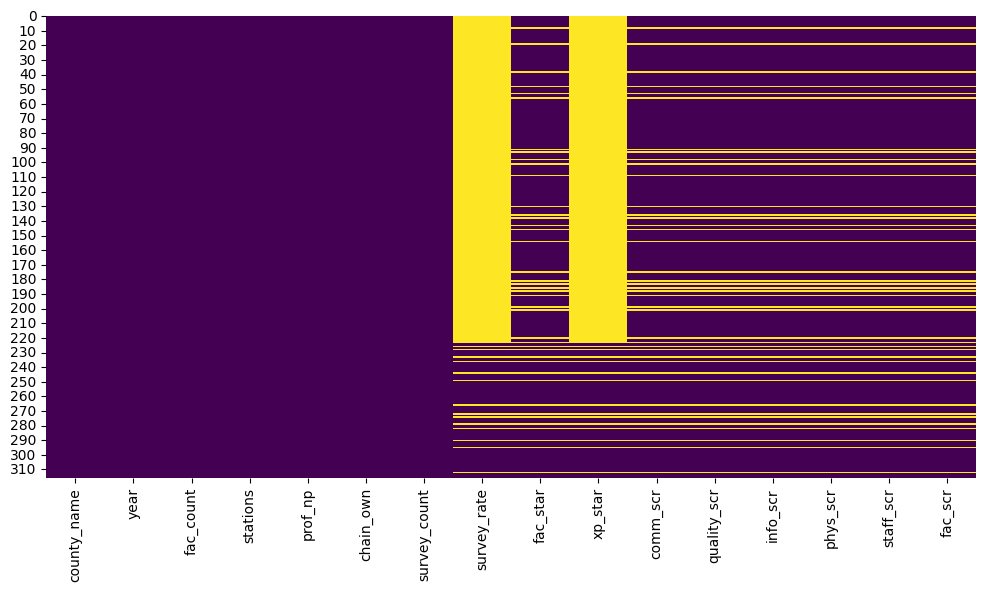

In [3]:
# Count missing values in each column
missing_counts = fascility_df.isnull().sum()
print(missing_counts)
# Visualizing missing data using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.heatmap(fascility_df.isnull(), cbar=False, cmap='viridis')